### Paquetes

In [65]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pandas as pd
from openai import OpenAI
import numpy as np
import json
import matplotlib.pyplot as plt

### Carga y procesamiento documento

In [2]:
loader = PyPDFLoader("llm_doc.pdf")
documents = loader.load()

In [3]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 100)
doc_splits = text_splitter.split_documents(documents)

In [4]:
data = [{'Chunks': doc.page_content, 'Metadata': doc.metadata} for doc in doc_splits]
df_vector_store = pd.DataFrame(data)
df_vector_store.head()

,Chunks,Metadata
0,Building Pipelines and Environments for \nLar...,"{'source': 'llm_doc.pdf', 'page': 0}"
1,Contents\nIntroduction to LLMOps 1\nWhy LLMOps...,"{'source': 'llm_doc.pdf', 'page': 1}"
2,1.\nIntroduction to LLMOps\nGenerative AI mode...,"{'source': 'llm_doc.pdf', 'page': 2}"
3,translation and even creative writing.\nUsing ...,"{'source': 'llm_doc.pdf', 'page': 2}"
4,"with LLMs. Together, these allow data scientis...","{'source': 'llm_doc.pdf', 'page': 2}"


### Creación y carga del vector store

In [17]:
file_name = open('credentials.json')
config_env = json.load(file_name)
api_key = config_env["openai_key"]
client = OpenAI(api_key=api_key)

In [7]:
def text_embedding(text=[]):
    embeddings = client.embeddings.create(model="text-embedding-ada-002", input=text, encoding_format="float")
    return embeddings.data[0].embedding

In [ ]:
df_vector_store["Embedding"] = df_vector_store["Chunks"].apply(lambda x: text_embedding([x]))
df_vector_store["Embedding"] = df_vector_store["Embedding"].apply(np.array)

df_vector_store.to_pickle('df_vector_store.pkl')

In [5]:
df_vector_store = pd.read_pickle('df_vector_store.pkl')
df_vector_store.head()

,Chunks,Metadata,Embedding
0,Building Pipelines and Environments for \nLar...,"{'source': 'llm_doc.pdf', 'page': 0}","[-0.00046735382, -0.012396803, 0.017612789, -0..."
1,Contents\nIntroduction to LLMOps 1\nWhy LLMOps...,"{'source': 'llm_doc.pdf', 'page': 1}","[0.0031267295, -0.0044250605, -0.0021370458, -..."
2,1.\nIntroduction to LLMOps\nGenerative AI mode...,"{'source': 'llm_doc.pdf', 'page': 2}","[-0.021221917, -0.00848473, -0.013968516, -0.0..."
3,translation and even creative writing.\nUsing ...,"{'source': 'llm_doc.pdf', 'page': 2}","[-0.006761361, -0.005447042, -0.0034913784, -0..."
4,"with LLMs. Together, these allow data scientis...","{'source': 'llm_doc.pdf', 'page': 2}","[0.00697415, -0.010129701, 0.0035339396, -0.05..."


### Busqueda semantica

In [8]:
def cosine_similarity(row):
    denominator1 = np.linalg.norm(row)
    denominator2 = np.linalg.norm(query_vector.ravel())
    dot_prod = np.dot(row, query_vector)
    return dot_prod/(denominator1*denominator2)

def get_context_from_query(query, vector_store, n_chunks = 5):
    global query_vector
    query_vector = np.array(text_embedding(query))
    top_matched = (
        vector_store["Embedding"]
        .apply(cosine_similarity)
        .sort_values(ascending=False)[:n_chunks]
        .index)
    top_matched_df = vector_store[vector_store.index.isin(top_matched)][["Chunks"]]
    return list(top_matched_df['Chunks'])

In [9]:
propios = pd.read_excel("Preguntas.xlsx")
propios

,PREGUNTA,RESPUESTA
0,¿Qué factores influyen en la selección de un m...,Requisitos técnicos y contexto.
1,¿Cuáles son las principales etapas en el entre...,Preprocesamiento y entrenamiento.
2,¿Qué diferencias existen entre modelos LLM de ...,Parámetros y capacidad de memoria.
3,¿Cómo se optimiza el rendimiento de un modelo ...,Fine-tuning y ajuste de hiperparámetros.
4,¿Qué herramientas se utilizan para evaluar un ...,Benchmarks y métricas de desempeño.
5,¿Qué consideraciones éticas se deben tener al ...,Privacidad y sesgo de los datos.
6,¿Qué tipos de datos son necesarios para entren...,Diversos y representativos del lenguaje.
7,¿Qué desafíos comunes se enfrentan al implemen...,Costo computacional y escalabilidad.


In [11]:
preguntas = propios['PREGUNTA']
respuestas = propios['RESPUESTA']

### Embeddings para las respuestas

In [ ]:
# 1. Respuesta
vector_1 = np.array(text_embedding(respuestas[0]))

In [26]:
# 2. Respuesta
vector_2 = np.array(text_embedding(respuestas[1]))

In [27]:
# 3. Respuesta
vector_3 = np.array(text_embedding(respuestas[2]))

In [28]:
# 4. Respuesta
vector_4 = np.array(text_embedding(respuestas[3]))

In [29]:
# 5. Respuesta
vector_5 = np.array(text_embedding(respuestas[4]))

In [30]:
# 6. Respuesta
vector_6 = np.array(text_embedding(respuestas[5]))

In [31]:
# 7. Respuesta
vector_7 = np.array(text_embedding(respuestas[6]))

In [32]:
# 8. Respuesta
vector_8 = np.array(text_embedding(respuestas[7]))

In [38]:
vector_respuestas = [vector_1,vector_2,vector_3,vector_4,
                     vector_5,vector_6,vector_7,vector_8]

In [39]:
vector_respuestas

[array([ 0.00411996, -0.01742982,  0.0233805 , ...,  0.00487204,
         0.01029824,  0.01479094]),
 array([-0.03569395, -0.00841042,  0.01548297, ...,  0.01682084,
        -0.03377157,  0.0087871 ]),
 array([-0.0071815 ,  0.00484751,  0.02256852, ...,  0.00381351,
        -0.02012149, -0.00950218]),
 array([-0.03014619,  0.00238158,  0.02191459, ...,  0.00963533,
        -0.01606797,  0.00206131]),
 array([-0.0324778 , -0.01149861,  0.03101508, ...,  0.00124094,
        -0.01191846, -0.00878986]),
 array([-0.00965966, -0.01300585,  0.03578697, ...,  0.01691724,
        -0.01052029,  0.01289025]),
 array([-0.01968504, -0.00447033,  0.01261296, ..., -0.01363809,
        -0.01372892, -0.01384571]),
 array([-1.7430803e-03, -3.0542828e-02,  2.8376670e-02, ...,
         3.0964000e-05, -1.5867108e-02, -7.9674000e-03])]

In [40]:
pd.to_pickle(vector_respuestas, "vector_respuestas.pkl")

### Respuestas del chatbot

In [14]:
custom_prompt = """
Eres una Inteligencia Artificial super avanzada que trabaja asistente personal.
Utilice los RESULTADOS DE BÚSQUEDA SEMANTICA para responder las preguntas del usuario.
Solo debes utilizar la informacion de la BUSQUEDA SEMANTICA si es que hace sentido y tiene relacion con la pregunta del usuario.
Si la respuesta no se encuentra dentro del contexto de la búsqueda semántica, no inventes una respuesta, y responde amablemente que no tienes información para responder.

RESULTADOS DE BÚSQUEDA SEMANTICA:
{source}

Lee cuidadosamente las instrucciones, respira profundo y escribe una respuesta para el usuario!
"""

In [ ]:
# 1. Respuesta
Context_list1 = get_context_from_query(query = preguntas[0], vector_store = df_vector_store, n_chunks = 5)
completion = client.chat.completions.create(model="gpt-4", temperature = 0.0,
                                            messages=[{"role": "system", "content": custom_prompt.format(source = str(Context_list1))},
                                                      {"role": "user", "content": preguntas[0]}])
respuesta_1 = completion.choices[0].message.content
respuesta_1

'La selección de un modelo de Lenguaje de Aprendizaje a Gran Escala (LLM) se basa en varios factores:\n\n1. Rendimiento del modelo en tareas de referencia: Esto se refiere a cómo se desempeña el modelo en tareas específicas y cómo se compara con otros modelos.\n\n2. Disponibilidad para ejecutarse en hardware menos costoso: Algunos modelos pueden requerir recursos de hardware significativos, lo que puede ser un factor limitante para algunas organizaciones.\n\n3. Disponibilidad de modelos pre-entrenados específicos del dominio: Algunos modelos están diseñados para tareas específicas, como BloombergGPT para la industria financiera, Med-PaLM2 y BioMedLM para el dominio médico, y Galactica, un LLM afinado con conocimiento científico.\n\n4. Términos de licencia del modelo de base: Esto se refiere a las condiciones bajo las cuales se puede utilizar el modelo. Algunas organizaciones pueden optar por un servicio de modelo administrado proporcionado por varios proveedores, mientras que otras pue

In [ ]:
# 1. Respuesta
Context_list1 = get_context_from_query(query = preguntas[0], vector_store = df_vector_store, n_chunks = 5)
completion1 = client.chat.completions.create(model="gpt-4", temperature = 0.0,
                                            messages=[{"role": "system", "content": custom_prompt.format(source = str(Context_list1))},
                                                      {"role": "user", "content": preguntas[0]}])
respuesta_1 = completion1.choices[0].message.content
respuesta_1

In [41]:
# 2. Respuesta
Context_list2 = get_context_from_query(query = preguntas[1], vector_store = df_vector_store, n_chunks = 5)
completion2 = client.chat.completions.create(model="gpt-4", temperature = 0.0,
                                            messages=[{"role": "system", "content": custom_prompt.format(source = str(Context_list2))},
                                                      {"role": "user", "content": preguntas[1]}])
respuesta_2 = completion2.choices[0].message.content
respuesta_2

'Las principales etapas en el entrenamiento de un modelo de lenguaje grande (LLM) según los resultados de la búsqueda semántica son:\n\n1. Recopilación, preparación y etiquetado de datos: Esta etapa implica la obtención de datos, asegurando su completitud, añadiendo etiquetas y realizando transformaciones de datos para generar características.\n\n2. Selección de modelos de base: Dado que el entrenamiento de LLMs desde cero es costoso y consume mucho tiempo, muchos investigadores y profesionales optan por utilizar LLMs preentrenados como modelos de base, que pueden ser afinados o adaptados a aplicaciones específicas con menos datos y recursos.\n\n3. Uso de modelos de lenguaje grande: Esto implica la afinación y el ajuste de los modelos para adaptarse a las necesidades específicas del proyecto.\n\n4. Evaluación de los modelos y control de versiones: Esta etapa implica la evaluación del rendimiento del modelo y el seguimiento de las diferentes versiones del modelo a lo largo del tiempo.\n

In [42]:
# 3. Respuesta
Context_list3 = get_context_from_query(query = preguntas[2], vector_store = df_vector_store, n_chunks = 5)
completion3 = client.chat.completions.create(model="gpt-4", temperature = 0.0,
                                            messages=[{"role": "system", "content": custom_prompt.format(source = str(Context_list3))},
                                                      {"role": "user", "content": preguntas[2]}])
respuesta_3 = completion3.choices[0].message.content
respuesta_3

'Los modelos de lenguaje a gran escala (LLM) de diferentes tamaños pueden tener variaciones en su rendimiento y capacidad para generalizar a partir de los datos de entrenamiento. Según los resultados de la búsqueda semántica, el enfoque FLAN, por ejemplo, reduce el rendimiento a tamaños más pequeños, y solo a escalas más altas el modelo puede generalizar a partir de las instrucciones de los datos de entrenamiento. Esto puede deberse a que los modelos más pequeños carecen de los parámetros necesarios para llevar a cabo una amplia gama de tareas. Además, muchos de los modelos LLM requieren hardware costoso y de alto rendimiento para funcionar y desplegarse, aunque cada vez hay más modelos inspirados en LLaMA, como Vicuna, que se pueden ejecutar en hardware menos costoso.'

In [43]:
# 4. Respuesta
Context_list4 = get_context_from_query(query = preguntas[3], vector_store = df_vector_store, n_chunks = 5)
completion4 = client.chat.completions.create(model="gpt-4", temperature = 0.0,
                                            messages=[{"role": "system", "content": custom_prompt.format(source = str(Context_list4))},
                                                      {"role": "user", "content": preguntas[3]}])
respuesta_4 = completion4.choices[0].message.content
respuesta_4

'El rendimiento de un modelo de Lenguaje de Gran Escala (LLM, por sus siglas en inglés) se puede optimizar de varias maneras. Una de ellas es a través de la infraestructura, la escalabilidad y el rendimiento. Los LLM requieren recursos computacionales significativos para la recopilación de datos de texto. Estos modelos a menudo están compuestos de múltiples capas y componentes, como transformadores, redes neuronales recurrentes, mecanismos de atención y embeddings. Entrenar estos modelos requiere recursos computacionales altos y algoritmos de optimización eficientes.\n\nAdemás, se pueden utilizar técnicas de ajuste fino, como se muestra en el ejemplo del modelo LLaMA-7B, que se ajustó utilizando instrucciones generadas por un modelo de lenguaje más grande. Este proceso de ajuste fino puede ser rentable.\n\nOtras técnicas de optimización incluyen la cuantización, que es una operación de compresión común utilizada para reducir la huella de memoria del modelo y mejorar el rendimiento de l

In [44]:
# 5. Respuesta
Context_list5 = get_context_from_query(query = preguntas[4], vector_store = df_vector_store, n_chunks = 5)
completion5 = client.chat.completions.create(model="gpt-4", temperature = 0.0,
                                            messages=[{"role": "system", "content": custom_prompt.format(source = str(Context_list5))},
                                                      {"role": "user", "content": preguntas[4]}])
respuesta_5 = completion5.choices[0].message.content
respuesta_5

'Los modelos de lenguaje a gran escala (LLM) se evalúan utilizando una variedad de métodos y métricas. Algunos de los métodos de evaluación comúnmente utilizados para los LLM incluyen:\n\n1. Perplejidad: Proporciona resultados en formato cuantitativo para determinar el nivel de rendimiento del modelo. Cuanto menor sea la perplejidad, mejor será el rendimiento. Se utiliza para determinar cuánto se sorprende el modelo al ver nuevos datos. La perplejidad se utiliza generalmente solo para determinar cuán extensamente un modelo ha aprendido el conjunto de entrenamiento.\n\n2. Métricas como BLEU y ROUGE: Se utilizan en el conjunto de pruebas para medir el rendimiento.\n\n3. Evaluación de recuperación: Se considera la tarea de recuperar imágenes a partir de consultas de oraciones. Dada una oración de prueba, se calcula la perplejidad del modelo condicionada a cada imagen de prueba y se clasifica.\n\n4. Evaluación de alucinación de subtítulos con relevancia de imagen (CHAIR): Es una estadístic

In [45]:
# 6. Respuesta
Context_list6 = get_context_from_query(query = preguntas[5], vector_store = df_vector_store, n_chunks = 5)
completion6 = client.chat.completions.create(model="gpt-4", temperature = 0.0,
                                            messages=[{"role": "system", "content": custom_prompt.format(source = str(Context_list6))},
                                                      {"role": "user", "content": preguntas[5]}])
respuesta_6 = completion6.choices[0].message.content
respuesta_6

'Al usar un modelo de lenguaje grande (LLM), hay varias consideraciones éticas que deben tenerse en cuenta. Los LLM pueden ser vulnerables a varios tipos de ataques, incluyendo ejemplos adversarios y manipulación. Los actores malintencionados podrían explotar estas vulnerabilidades para generar contenido engañoso o dañino, difundir desinformación o participar en otras actividades nefastas.\n\nAdemás, los LLM pueden filtrar información sensible de los datos de entrenamiento o podrían memorizar y reproducir inadvertidamente detalles privados o identificables personalmente, lo que plantea problemas de privacidad para las personas cuyos datos se utilizan en el proceso de entrenamiento.\n\nEl despliegue no controlado de LLM podría llevar a la generación de contenido sesgado, ofensivo o discriminatorio. Se necesitan mecanismos de gobernanza adecuados para asegurar que las salidas de estos modelos se alineen con los estándares éticos y no perpetúen sesgos dañinos.\n\nFinalmente, generar conte

In [46]:
# 7. Respuesta
Context_list7 = get_context_from_query(query = preguntas[6], vector_store = df_vector_store, n_chunks = 5)
completion7 = client.chat.completions.create(model="gpt-4", temperature = 0.0,
                                            messages=[{"role": "system", "content": custom_prompt.format(source = str(Context_list7))},
                                                      {"role": "user", "content": preguntas[6]}])
respuesta_7 = completion7.choices[0].message.content
respuesta_7

'Los modelos de Lenguaje a Gran Escala (LLM, por sus siglas en inglés) requieren cantidades masivas de datos para su entrenamiento. Estos datos suelen ser textuales y su recolección puede ser un desafío, especialmente si los datos son específicos para un dominio o tarea particular. La calidad de los datos es crítica para el rendimiento de los modelos LLM. Cualquier sesgo o inconsistencia en los datos puede ser amplificado por el modelo, lo que puede llevar a un rendimiento deficiente. Si los datos son ruidosos o inconsistentes, pueden llevar a errores en el modelo, como la generación de texto incorrecto o sin sentido. La etiquetación de los datos para tales tareas puede ser una actividad costosa, que consume mucho tiempo y es compleja, que requiere expertos humanos, conocimientos del dominio o directrices específicas.'

In [47]:
# 8. Respuesta
Context_list8 = get_context_from_query(query = preguntas[7], vector_store = df_vector_store, n_chunks = 5)
completion8 = client.chat.completions.create(model="gpt-4", temperature = 0.0,
                                            messages=[{"role": "system", "content": custom_prompt.format(source = str(Context_list8))},
                                                      {"role": "user", "content": preguntas[7]}])
respuesta_8 = completion8.choices[0].message.content
respuesta_8

'Los desafíos comunes al implementar modelos de Lenguaje de Gran Escala (LLM) incluyen:\n\n1. Infraestructura, escalado y rendimiento: Los LLM requieren recursos computacionales significativos para la recopilación de datos de texto. Los LLM a menudo están compuestos de múltiples capas y componentes, como transformadores, redes neuronales recurrentes, mecanismos de atención y embeddings. Entrenar estos modelos requiere altos recursos computacionales y algoritmos de optimización eficientes.\n\n2. Ambigüedad de los lenguajes naturales: Los prompts pueden ser interpretados de manera diferente por los usuarios y los LLM, lo que puede llevar a fallos silenciosos o salidas inesperadas. La ingeniería de prompts requiere métodos rigurosos de evaluación, versionado y optimización para garantizar la calidad y la consistencia.\n\n3. Compatibilidad hacia atrás y hacia adelante: Los LLM están en constante evolución y actualización, lo que puede afectar el comportamiento y rendimiento de los prompts 

In [50]:
respuestas_chat = [respuesta_1,respuesta_2,respuesta_3,respuesta_4, 
                   respuesta_5,respuesta_6,respuesta_7, respuesta_8]
pd.to_pickle(respuestas_chat, "respuestas_chat.pkl")

### Comparación respuestas

In [16]:
def cosine_test(row1, row2):
    denominator1 = np.linalg.norm(row1.ravel())
    denominator2 = np.linalg.norm(row2.ravel())
    dot_prod = np.dot(row1, row2)
    return dot_prod/(denominator1*denominator2)

In [ ]:
vector_respuesta1 = np.array(text_embedding(respuesta_1))
vector_respuesta2 = np.array(text_embedding(respuesta_2))
vector_respuesta3 = np.array(text_embedding(respuesta_3))
vector_respuesta4 = np.array(text_embedding(respuesta_4))
vector_respuesta5 = np.array(text_embedding(respuesta_5))
vector_respuesta6 = np.array(text_embedding(respuesta_6))
vector_respuesta7 = np.array(text_embedding(respuesta_7))
vector_respuesta8 = np.array(text_embedding(respuesta_8))

In [59]:
vector_respuestas_chat = [vector_respuesta1, vector_respuesta2, vector_respuesta3, vector_respuesta4,
                          vector_respuesta5, vector_respuesta6, vector_respuesta7, vector_respuesta8]
pd.to_pickle(vector_respuestas_chat, "vector_respuestas_chat.pkl")

In [61]:
similitudes = [cosine_test(vector_1, vector_respuesta1),
               cosine_test(vector_2, vector_respuesta2),
               cosine_test(vector_3, vector_respuesta3),
               cosine_test(vector_4, vector_respuesta4),
               cosine_test(vector_5, vector_respuesta5),
               cosine_test(vector_6, vector_respuesta6),
               cosine_test(vector_7, vector_respuesta7),
               cosine_test(vector_8, vector_respuesta8)]
similitudes

[0.8116081861015266,
 0.842869827145529,
 0.7968801204958689,
 0.8265532351943105,
 0.8376553020236562,
 0.7934903023778033,
 0.8133002750230917,
 0.8264850030589421]

In [ ]:
precision = [1 if x >= 0.8 else 0 for x in similitudes]
precision

[1, 1, 0, 1, 1, 0, 1, 1]

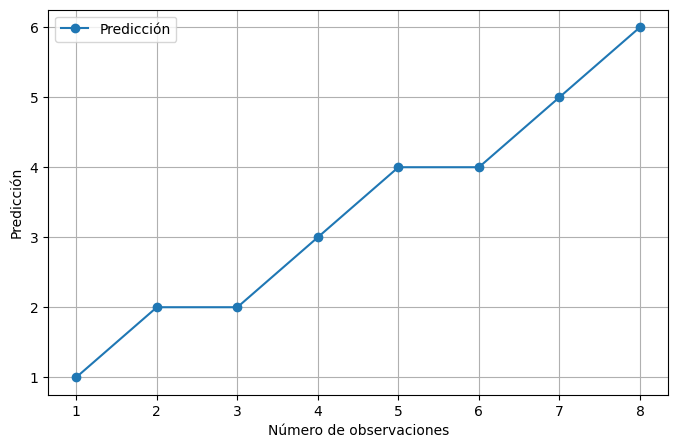

In [86]:
n_observaciones = len(precision)
acumulado = np.cumsum(precision)
accuracy = acumulado / np.arange(1, n_observaciones + 1) 

plt.figure(figsize=(8, 5))
plt.plot(range(1, n_observaciones + 1), acumulado, marker='o', label='Predicción')

plt.xlabel('Número de observaciones')
plt.ylabel('Predicción')
plt.xticks(range(1, n_observaciones + 1))
plt.legend()
plt.grid()

plt.show()

In [85]:
f"El accuracy final del chatbot fue de {6/8}"

'El accuracy final del chatbot fue de 0.75'